# Лабораторная работа №7 по курсу "Численные методы"
## Тема ЛР - "Краевые задачи для дифференциального уравнения эллиптического типа"

Студент - Письменский Данила Владимирович

Группа - М8О-406Б-19

## Задание

Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением *U(x, y)*.

### Вариант 1

$\large\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0$  
$u(0, y) = y$  
$u(1, y) = 1 + y$  
$u(x, 0) = x$  
$u(x, 1) = 1 + x$  
Аналитическое решение: $U(x, y) = x + y$

In [1]:
# импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt

### Константы

In [2]:
x_start = 0
x_end = 1.05

y_start = 0
y_end = 1.05

h_x = 0.05
h_y = 0.05

### Начальные условия

In [3]:
# граничные условия по x
def phi_0(y):
    return y

def phi_1(y):
    return 1 + y

# граничные условия по y
def psi_0(x):
    return x

def psi_1(x):
    return 1 + x

def exact_sol(x, y):
    return x + y

### Аналитическое решение
Найдем аналитическое решение начально-краевой задачи для дифференциального уравнения эллиптического типа, затем будем сравнивать его с численными методами для того. Это нам пригодится, чтобы визуализировать зависимость максимального модуля ошибки от координаты *y*. Для этого реализовал функцию, которая возвращает матрицу *U* со значениями функции для аналитического решения.

In [4]:
def analytical_solve(x_start, x_end, y_start, y_end, h_x, h_y):
    x = np.arange(x_start, x_end, h_x)
    y = np.arange(y_start, y_end, h_y)

    U = np.zeros((len(x), len(y)))
    for i_x in range(len(x)):
        for i_y in range(len(y)):
            U[i_y][i_x] = exact_sol(x[i_x], y[i_y])
    
    return U

In [5]:
anal_solution = analytical_solve(x_start, x_end, y_start, y_end, h_x, h_y)

In [6]:
anal_solution.shape

(21, 21)

### Погрешность
В качестве погрешности буду использовать максимальный модуль ошибки.

In [7]:
def max_abs_error(U_num, U_anal):
    return abs(U_num - U_anal).max()

### L2 норма
Является геометрическим расстоянием между двумя точками в многомерном пространстве, вычисляемым по теореме Пифагора.  
Формула: $\large||X||_2 = \left( \sum^N_{i=1}|x_i|^2\right)^{1 \over 2}$

In [8]:
def L2_norm(X):
    n = X.shape[0]
    l2_norm = 0
    for i in range(n):
        l2_norm += X[i] ** 2
    return np.sqrt(l2_norm)

### Реализация функций построения графиков
Для того, чтобы визуализировать решение ДУ численными методами, реализую функцию построения графика функции *U(x)* при заданной координате *y*.

In [9]:
def build_numerical_results_graphic(solution, method_name, coord_y, x_start, x_end, y_start, y_end, h_x, h_y):
    x = np.arange(x_start, x_end, h_x)
    y = np.arange(y_start, y_end, h_y)
    cur_y_id = abs(y - coord_y).argmin()

    plt.figure(figsize=(15, 9))
    plt.plot(x, anal_solution[cur_y_id], label='Аналитическое решение')
    plt.plot(x, solution[cur_y_id], label=method_name, color='r')
    
    plt.xlabel('x')
    plt.ylabel('U(x)')
    plt.legend()
    plt.grid()
    plt.show()

Чтобы проверить, наскольно точно решение ДУ численными методами, необходимо реализовать функцию построения графика зависимости погрешности (максимального модуля ошибки) от координаты *y*.

In [10]:
def build_errors_graphic(solution, method_name, y_start, y_end, h_y):
    y = np.arange(y_start, y_end, h_y)

    plt.figure(figsize=(15, 9))
    max_abs_errors = np.array([max_abs_error(solution[i], anal_solution[i]) for i in range(len(y))])
    plt.plot(y, max_abs_errors, label=method_name, color='g')

    plt.xlabel('y')
    plt.ylabel('Максимальный модуль ошибки')

    plt.legend()
    plt.grid()
    plt.show()

## Численные методы

### Конечно-разностная схема

Преобразуем исходное уравнение с производными в уравнение с их численными приближениями.

$\large u_{i,j} - (u_{i,j-1} + u_{i, j+1}) \frac{h_x^2}{2(h_x^2+h_y^2)} - (u_{i-1, j} + u_{i+1, j}) \frac{h_y^2}{2(h_x^2+h_y^2)} = 0$  

Получили рекуррентное соотношение.  

Записав такое соотношение для всех *i*, *j* получим систему уравнений. Решить ее можно итерационными способами.


In [11]:
def finite_difference_schema(method, x_start, x_end, y_start, y_end, h_x, h_y, phi_0, phi_1, psi_0, psi_1, eps=1e-7):
    x = np.arange(x_start, x_end, h_x)
    y = np.arange(y_start, y_end, h_y)

    # Шаг 1. Инициализируем сетку граничными условиями
    n = len(x)
    m = len(y)
    U = np.zeros((n, m))
    # Используем начальные условия по y
    for x_i in range(n):
        U[x_i][0] = psi_0(x[x_i])
        U[x_i][m - 1] = psi_1(x[x_i])
    
    # Используем начальные условия по x
    for y_i in range(m):
        U[0][y_i] = phi_0(y[y_i])
    
    for y_i in range(m):
        U[n - 1][y_i] = phi_1(y[y_i])

    # Шаг 2. Создаём систему уравнений
    bits_map = np.zeros((n, m), dtype='int') # bits_map[i][j] = номер уравнения, где u_{i,j} = 1
    curr_equation_id = 0
    for x_i in range(1, n - 1):
        for y_i in range(1, m - 1):
            bits_map[x_i][y_i] = curr_equation_id
            curr_equation_id += 1
    
    nums_of_equations = (n - 2) * (m - 2)
    A = np.zeros((nums_of_equations, nums_of_equations))
    b = np.zeros((nums_of_equations))
    for x_i in range(1, n - 1):
        for y_i in range(1, m - 1):
            curr_equation_id = bits_map[x_i][y_i]
            A[curr_equation_id][bits_map[x_i][y_i]] = 1
            if y_i - 1 == 0:
                # u_{i, j-1} вычислили из граничных условиях
                b[curr_equation_id] += psi_0(x[x_i]) * h_x ** 2 / (2 * (h_x **2 + h_y ** 2))
            else:
                A[curr_equation_id][bits_map[x_i][y_i - 1]] = -h_x ** 2 / (2 * (h_x ** 2 + h_y ** 2))
            if y_i + 1 == m - 1:
                # u_{i, j+1} вычислили из граничных условиях
                b[curr_equation_id] += psi_1(x[x_i]) * h_x**2 / (2 * (h_x**2 + h_y**2))
            else:
                A[curr_equation_id][bits_map[x_i][y_i + 1]] = -h_x**2 / (2 * (h_x**2 + h_y**2))
            if x_i - 1 == 0:
                # u_{i-1, j} вычислили из граничных условиях
                b[curr_equation_id] += phi_0(y[y_i]) * h_y**2 / (2 * (h_x**2 + h_y**2))
            else:
                A[curr_equation_id][bits_map[x_i - 1][y_i]] = -h_y**2 / (2 * (h_x**2 + h_y**2))
            if x_i + 1 == n - 1:
                # u_{i+1, j} вычислили из граничных условиях
                b[curr_equation_id] += phi_1(y[y_i]) * h_y**2 / (2 * (h_x**2 + h_y**2))
            else:
                A[curr_equation_id][bits_map[x_i + 1][y_i]] = -h_y**2 / (2 * (h_x**2 + h_y**2))
    
    # Шаг 3. Решаем систему уравнений
    eq_answer, iterations = method(A, b, eps)
    for x_i in range(1, n - 1):
        for y_i in range(1, m - 1):
            U[x_i][y_i] = eq_answer[bits_map[x_i][y_i]]

    return U, iterations

### Метод простых итераций для решения СЛАУ

In [12]:
def iterative_method(A, b, eps):
    n = A.shape[0]
    a = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                a[i][j] = 0
            else:
                a[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_x = np.copy(beta)
    not_converge = True
    while not_converge:
        prev_x = np.copy(cur_x)
        cur_x = a @ prev_x + beta
        iterations += 1
        not_converge = L2_norm(prev_x - cur_x) > eps
    return cur_x, iterations

### Решениие системы из конечно-разностной схемы с помощью метода простых итераций

In [13]:
iterative_solution, iterative_iterations = finite_difference_schema(iterative_method, x_start, x_end, y_start, y_end, h_x, h_y, phi_0, phi_1, psi_0, psi_1)

In [14]:
iterative_solution.shape

(21, 21)

### Максимальный модуль ошибки для метода простых итераций

In [15]:
print(f'Максимальный модуль ошибки для метода простых итераций = {max_abs_error(iterative_solution, anal_solution)}')

Максимальный модуль ошибки для метода простых итераций = 7.991032175969082e-07


### Количество итераций для метода простых итераций

In [16]:
print(f'Количество итераций для метода простых итераций = {iterative_iterations}')

Количество итераций для метода простых итераций = 1171


### Визуализация решения системы  из конечно-разностной схемы с помощью метода простых итераций

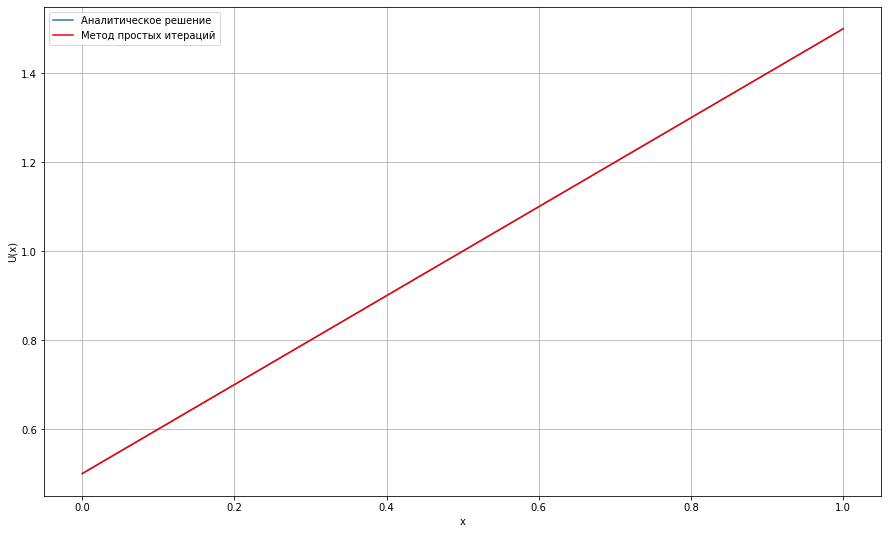

In [17]:
build_numerical_results_graphic(iterative_solution, "Метод простых итераций", 0.5, x_start, x_end, y_start, y_end, h_x, h_y)

### Визуализация погрешности метода простых итераций

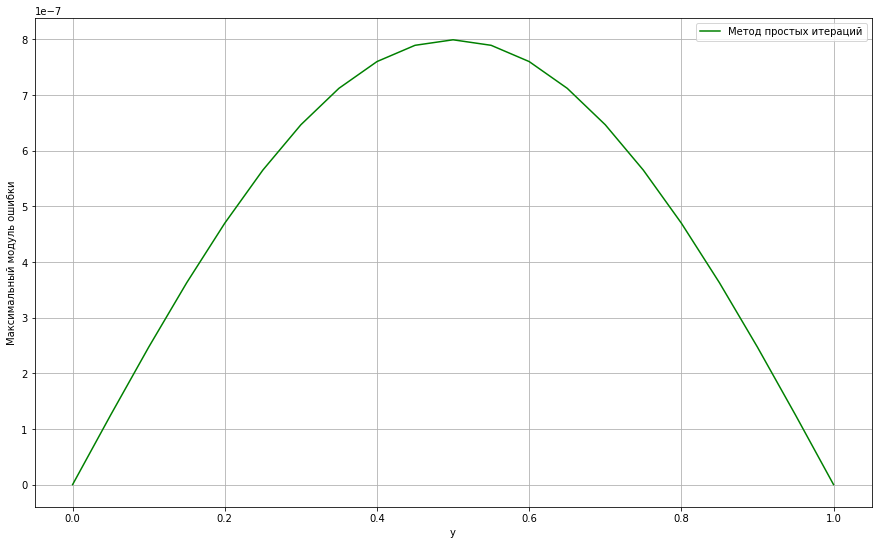

In [18]:
build_errors_graphic(iterative_solution, "Метод простых итераций", y_start, y_end, h_y)

### Метод Зейделя для решения СЛАУ

In [19]:
# функция считает alpha * x + beta для метода Зейделя
def seidel_multiplication(x, alpha, beta):
    ans = np.copy(x)
    for i in range(alpha.shape[0]):
        ans[i] = beta[i]
        for j in range(alpha.shape[1]):
            ans[i] += alpha[i][j] * ans[j]
    return ans


def seidel_method(A, b, eps):
    n = A.shape[0]

    # Находим alpha и beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]
        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_ans = np.copy(beta)
    not_converge = True
    while not_converge:
        prev_ans = np.copy(cur_ans)
        cur_ans = seidel_multiplication(prev_ans, alpha, beta)
        iterations += 1
        not_converge = L2_norm(prev_ans - cur_ans) > eps
    return cur_ans, iterations


### Решение системы из конечно-разностной схемы с помощью метода Зейделя

In [20]:
seidel_solution, seidel_iterations = finite_difference_schema(seidel_method, x_start, x_end, y_start, y_end, h_x, h_y, phi_0, phi_1, psi_0, psi_1)

In [21]:
seidel_solution.shape

(21, 21)

### Максимальный модуль ошибки для метода Зейделя

In [22]:
print(f'Максимальный модуль ошибки для метода Зейделя = {max_abs_error(seidel_solution, anal_solution)}')

Максимальный модуль ошибки для метода Зейделя = 3.9464804979516543e-07


### Количество итераций для метода Зейделя

In [23]:
print(f'Количество итераций для метода Зейделя = {seidel_iterations}')

Количество итераций для метода Зейделя = 617


### Визуализация решения системы  из конечно-разностной схемы с помощью метода Зейделя

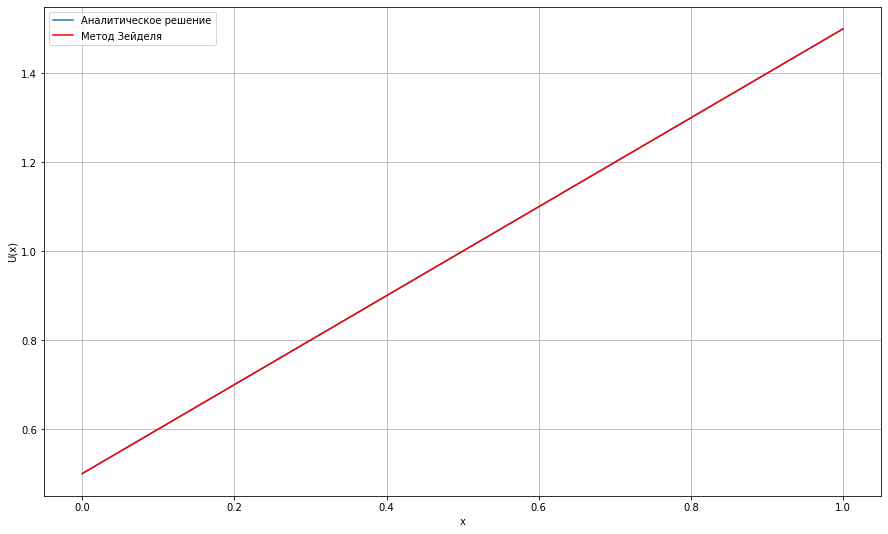

In [24]:
build_numerical_results_graphic(seidel_solution, "Метод Зейделя", 0.5, x_start, x_end, y_start, y_end, h_x, h_y)

### Визуализация погрешности метода Зейделя

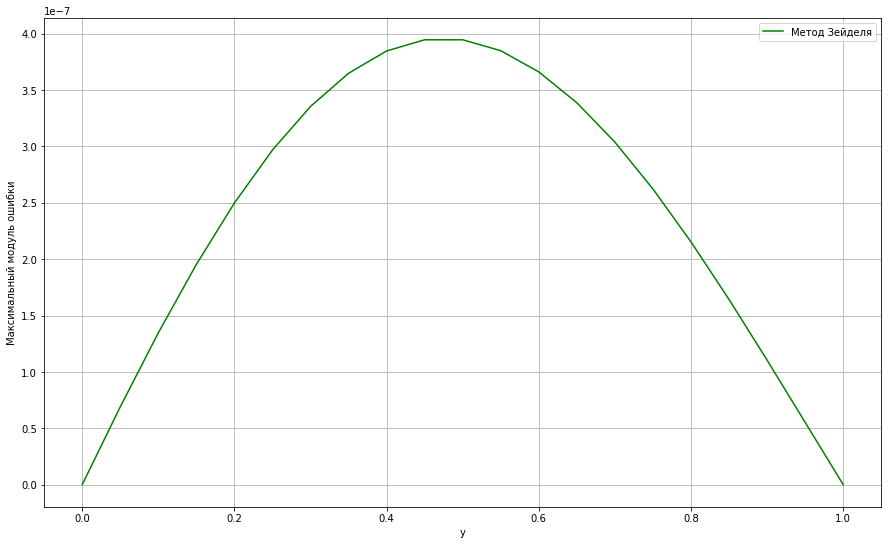

In [25]:
build_errors_graphic(seidel_solution, "Метод Зейделя", y_start, y_end, h_y)

In [26]:
print(f'Количество итераций для метода простых итераций = {iterative_iterations}')
print(f'Количество итераций для метода Зейделя = {seidel_iterations}')

Количество итераций для метода простых итераций = 1171
Количество итераций для метода Зейделя = 617


Из сравнения количества итераций для обоих методов можно сделать вывод о том, что метод Зейделя сходится за меньшее количество итераций, чем метод простых итераций (в 1.9 раза меньше).

### Метод верхних релаксаций для решения СЛАУ

Метод верхних релаксаций для решения СЛАУ является модификацией метода Зейделя, заключающийся в том, что новое значение неизвестных расчитывается как среднее взвешенное значений на текущей и прошлой итерации.  

Данное изменение позволяет обеспечить более быструю сходимость.

In [27]:
def upper_relaxations_method(A, b, eps, w=1.47):
    n = A.shape[0]

    # Вычисляем alpha и beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]
        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_ans = np.copy(beta)
    not_converge = True
    while not_converge:
        prev_ans = np.copy(cur_ans)
        cur_ans = seidel_multiplication(prev_ans, alpha, beta)
        cur_ans = w * cur_ans + (1-w) * prev_ans
        iterations += 1
        not_converge = L2_norm(prev_ans - cur_ans) > eps
    return cur_ans, iterations

### Решение системы из конечно-разностной схемы с помощью метода верхних релаксаций

In [28]:
upper_relaxations_solution, upper_relaxations_iterations = finite_difference_schema(upper_relaxations_method, x_start, x_end, y_start, y_end, h_x, h_y, phi_0, phi_1, psi_0, psi_1)

In [29]:
upper_relaxations_solution.shape

(21, 21)

### Максимальный модуль ошибки для метода верхних релаксаций

In [30]:
print(f'Максимальный модуль ошибки для метода верхних релаксаций = {max_abs_error(upper_relaxations_solution, anal_solution)}')

Максимальный модуль ошибки для метода верхних релаксаций = 2.6626110694039085e-07


### Количество итераций для метода верхних релаксаций

In [31]:
print(f'Количество итераций для метода верхних релаксаций = {upper_relaxations_iterations}')

Количество итераций для метода верхних релаксаций = 428


### Визуализация решения системы  из конечно-разностной схемы с помощью метода верхних релаксаций

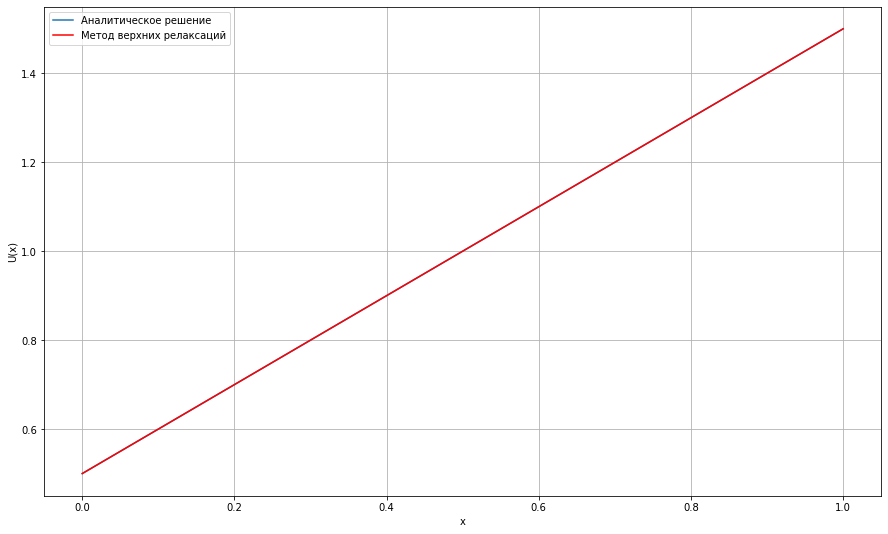

In [32]:
build_numerical_results_graphic(upper_relaxations_solution, "Метод верхних релаксаций", 0.5, x_start, x_end, y_start, y_end, h_x, h_y)

### Визуализация погрешности метода верхних релаксаций

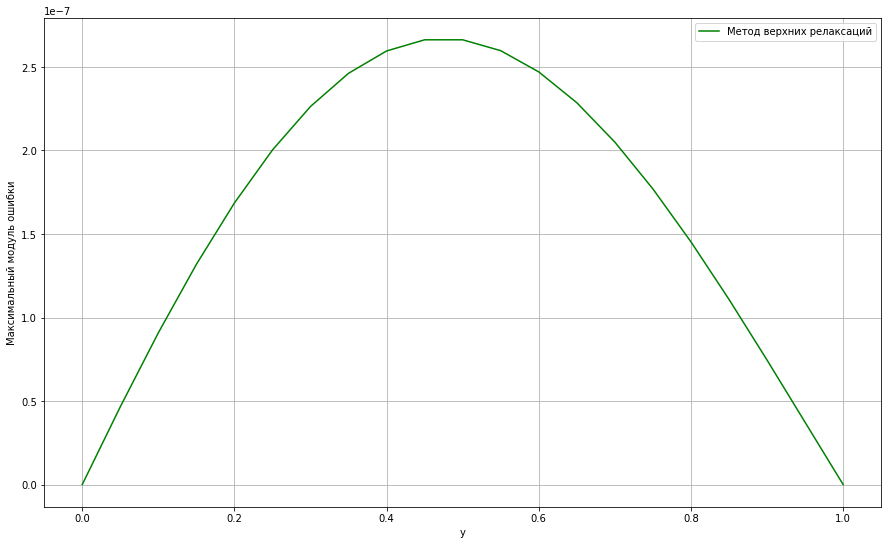

In [33]:
build_errors_graphic(upper_relaxations_solution, "Метод верхних релаксаций", y_start, y_end, h_y)

In [34]:
print(f'Количество итераций для метода Зейделя = {seidel_iterations}')
print(f'Количество итераций для метода верхних релаксаций = {upper_relaxations_iterations}')

Количество итераций для метода Зейделя = 617
Количество итераций для метода верхних релаксаций = 428


Как и ожидалось, метод верних релаксаций сходится за меньшее количество итераций, чем метод Зейделя.

### Сравнение численных методов с аналитическим решением

In [35]:
def build_all_numerical_results_graphic(sol1, sol2, sol3, m_n1, m_n2, m_n3, coord_y, x_start, x_end, y_start, y_end, h_x, h_y):
    x = np.arange(x_start, x_end, h_x)
    y = np.arange(y_start, y_end, h_y)
    cur_y_id = abs(y - coord_y).argmin()

    plt.figure(figsize=(15, 9))
    plt.plot(x, anal_solution[cur_y_id], label='Аналитическое решение')
    plt.plot(x, sol1[cur_y_id], label=m_n1, color='r')
    plt.plot(x, sol2[cur_y_id], label=m_n2, color='g')
    plt.plot(x, sol3[cur_y_id], label=m_n3, color='m')
    
    plt.xlabel('y')
    plt.ylabel('U(x)')
    plt.legend()
    plt.grid()
    plt.show()

In [36]:
def build_all_errors_graphic(sol1, sol2, sol3, m_n1, m_n2, m_n3, y_start, y_end, h_y):
    y = np.arange(y_start, y_end, h_y)

    plt.figure(figsize=(15, 9))
    max_abs_errors1 = np.array([max_abs_error(sol1[i], anal_solution[i]) for i in range(len(y))])
    max_abs_errors2 = np.array([max_abs_error(sol2[i], anal_solution[i]) for i in range(len(y))])
    max_abs_errors3 = np.array([max_abs_error(sol3[i], anal_solution[i]) for i in range(len(y))])
    plt.plot(y, max_abs_errors1, label=m_n1, color='g')
    plt.plot(y, max_abs_errors2, label=m_n2, color='r')
    plt.plot(y, max_abs_errors3, label=m_n3, color='b')
    
    plt.xlabel('y')
    plt.ylabel('Максимальный модуль ошибки')

    plt.legend()
    plt.grid()
    plt.show()

### Визуализация результатов работы численных методов

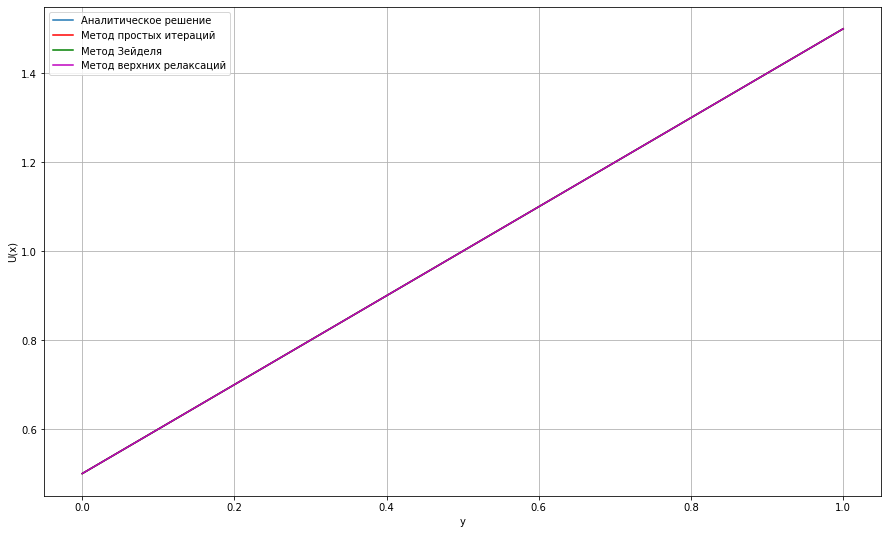

In [37]:
build_all_numerical_results_graphic(iterative_solution, seidel_solution, upper_relaxations_solution, "Метод простых итераций", "Метод Зейделя", "Метод верхних релаксаций", 0.5, x_start, x_end, y_start, y_end, h_x, h_y)

### Визуализация зависимости погрешности от координаты y для численных методов

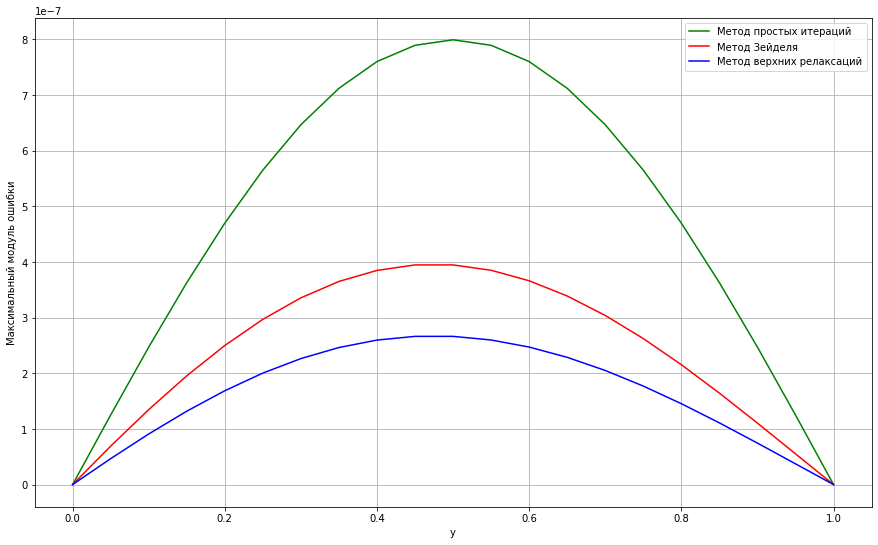

In [38]:
build_all_errors_graphic(iterative_solution, seidel_solution, upper_relaxations_solution, "Метод простых итераций", "Метод Зейделя", "Метод верхних релаксаций", y_start, y_end, h_y)

## Вывод

В ходе данной лабораторной работы научился решать краевые задачи для дифференциального уравнения эллиптического типа с помощью конечно-разностной схемы.

Применение конечно-разностной схемы позволяет нам получить СЛАУ, решаемую с помощью следующих методов:
- метод простых итераций (метод Либмана);
- метод Зейделя;
- метод верхних релаксаций;

Получил довольно точное решение ДУ с помощью каждого метода, однако, из общего графика зависимости погрешности от коодинаты *y* можно сделать вывод о том, что метод верних релаксаций является наиболее точным среди остальных реализованных методов решения ДУ.